In [2]:
import torch
from transformers import AutoModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc
import torch.nn.functional as f

# Вначале для удобства лучше все тестировать на 70M модели,
# но для итоговой презентации наверное нужно будет все прогнать на 2.7 B модели
model_name = "EleutherAI/pythia-410M"

checkpoint_steps = [0] + [2**i for i in range(1, 10)] + list(range(1000, 143001, 1000))
branch_names = [f"step{step}" for step in checkpoint_steps]

# Посмотрим как выглядит архитектура модели и как её доставать
model = AutoModel.from_pretrained(model_name, revision=branch_names[-1], trust_remote_code=True)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

GPTNeoXModel(
  (embed_in): Embedding(50304, 1024)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-23): 24 x GPTNeoXLayer(
      (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (post_attention_dropout): Dropout(p=0.0, inplace=False)
      (post_mlp_dropout): Dropout(p=0.0, inplace=False)
      (attention): GPTNeoXSdpaAttention(
        (rotary_emb): GPTNeoXRotaryEmbedding()
        (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp): GPTNeoXMLP(
        (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
        (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELUActivation()
      )
    )
  )
  (final_layer_n

In [24]:
sigma_up_dict = {layer_idx: [] for layer_idx in range(24)}
sigma_down_dict = {layer_idx: [] for layer_idx in range(24)}

for layer_idx, layer in enumerate(model.layers):
    print(layer_idx)
    mlp = layer.mlp
    up = mlp.dense_h_to_4h.weight.detach()
    down = mlp.dense_4h_to_h.weight.detach().T
    up = f.normalize(up, p=2, dim=1)
    down = f.normalize(down, p=2, dim=1)

    sigma_up = up@up.T
    sigma_down = down@down.T
    array_up = []
    array_down = []

    d, d = sigma_up.shape
    for i in range(0, d, 13):
        for j in range(0, d, 13):
            if i < j:
                array_up.append((1/np.pi)*180*torch.arccos(sigma_up[i][j]))
                array_down.append((1/np.pi)*180*torch.arccos(sigma_down[i][j]))

    sigma_up_dict[layer] = np.array(array_up)
    sigma_down_dict[layer] = np.array(array_down)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


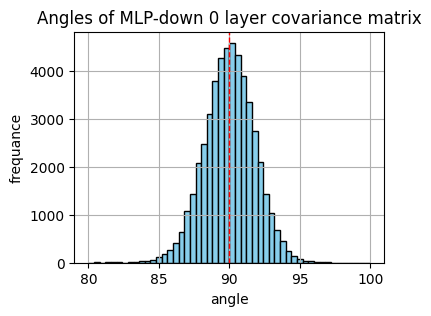

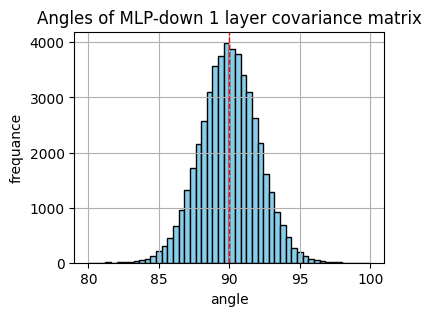

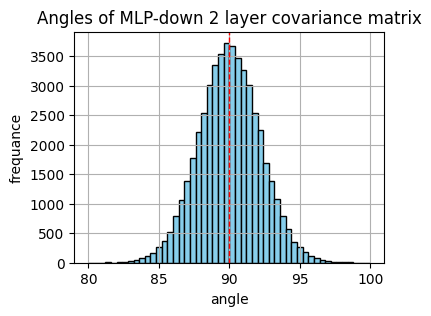

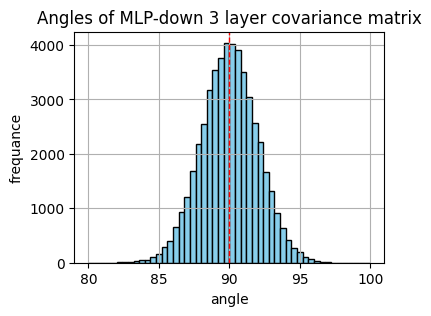

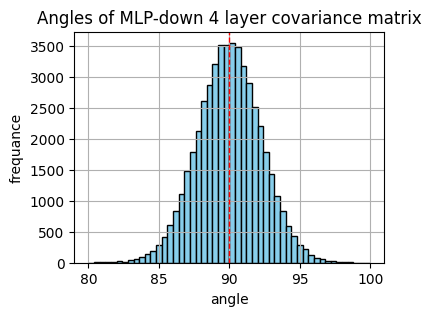

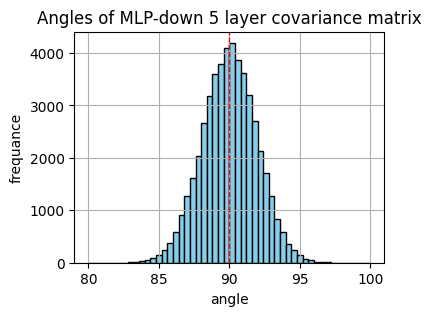

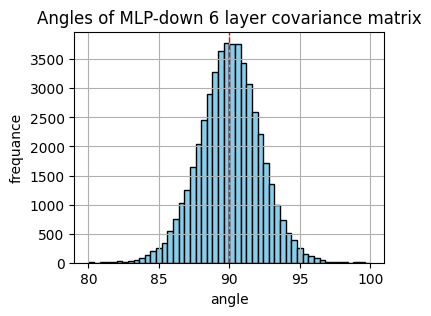

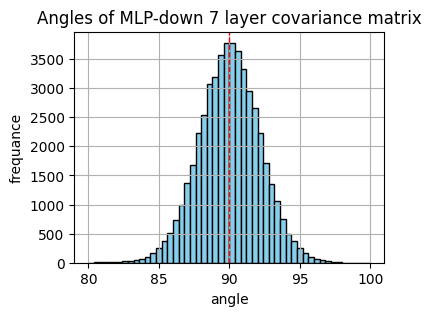

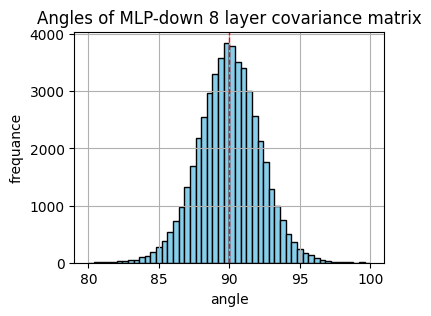

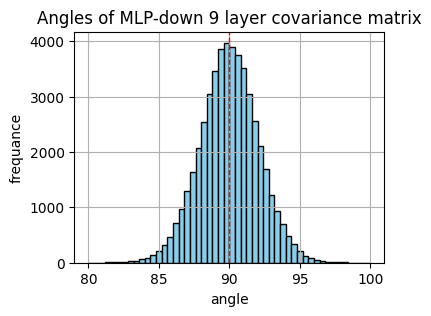

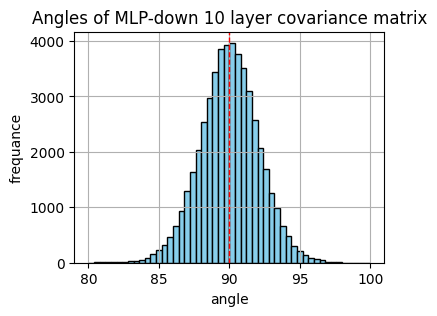

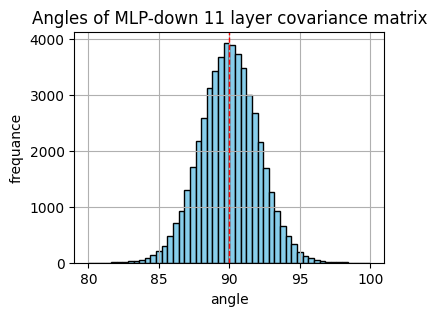

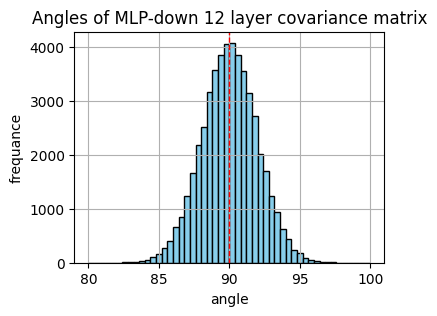

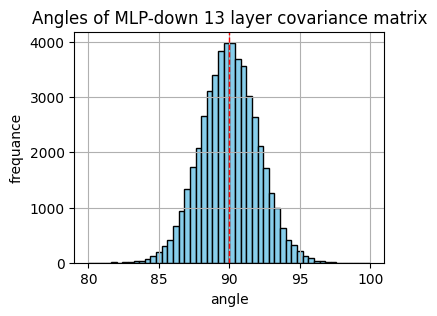

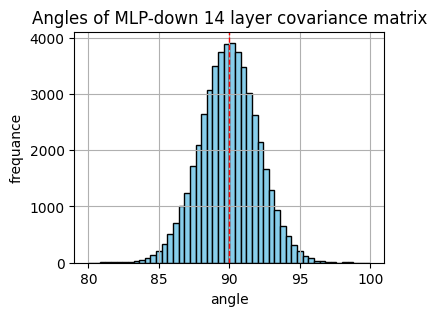

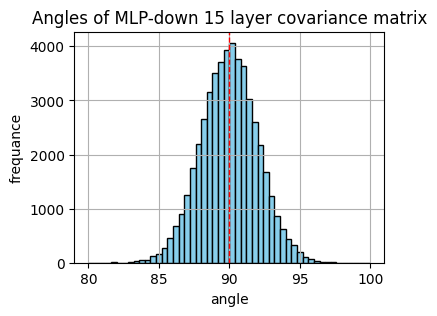

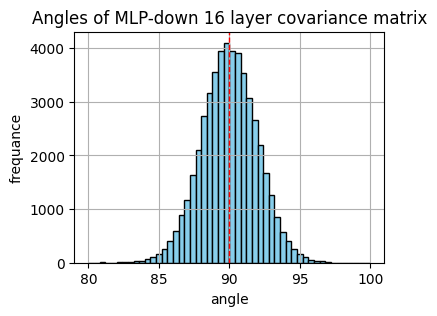

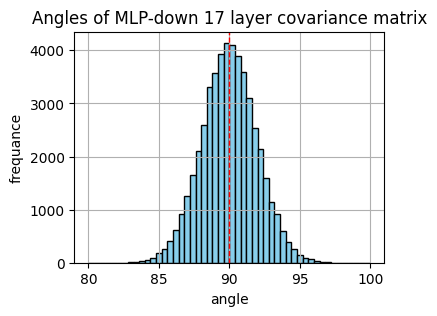

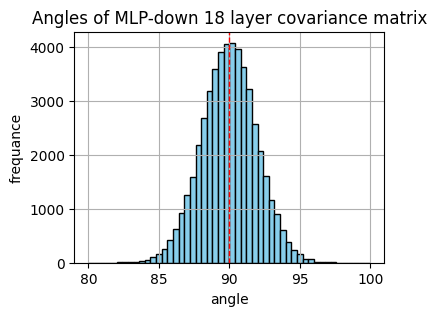

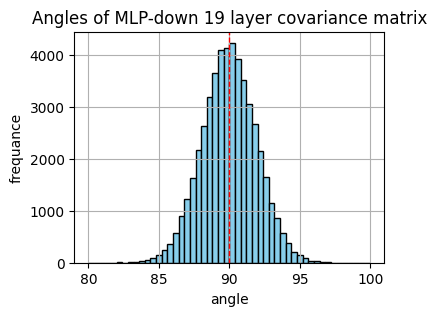

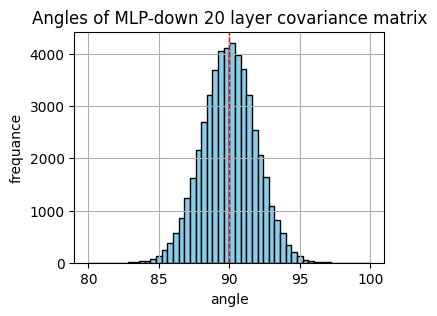

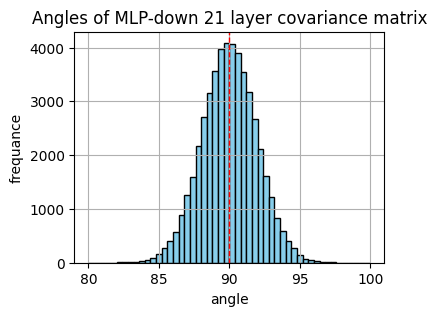

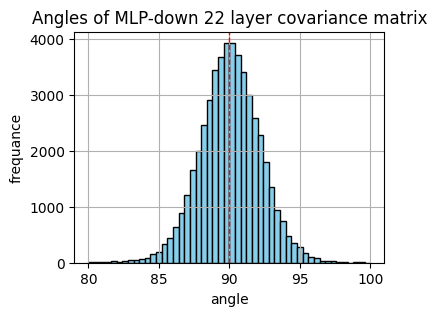

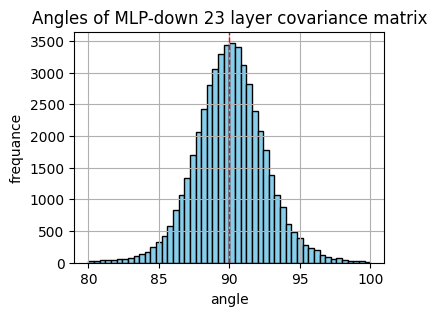

In [27]:
for layer_idx, layer in enumerate(model.layers):
  data = np.array(sigma_down_dict[layer])
  plt.figure(figsize=(4, 3))
  plt.hist(data, bins=50, range=(80, 100), color='skyblue', edgecolor='black')
  plt.axvline(90, color='red', linestyle='dashed', linewidth=1)
  plt.title(f'Angles of MLP-down {layer_idx} layer covariance matrix')
  plt.xlabel('angle')
  plt.ylabel('frequance')
  plt.grid(True)
  plt.show()

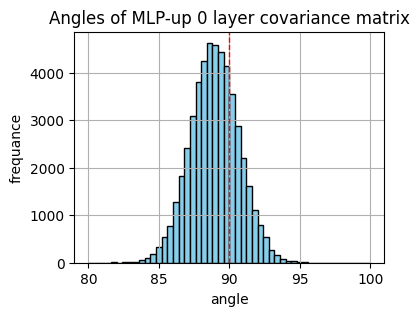

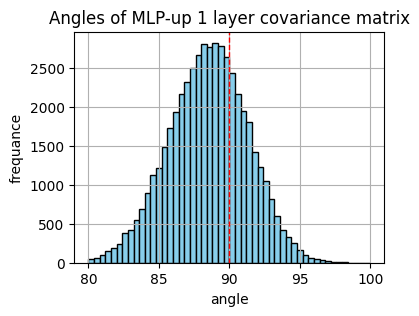

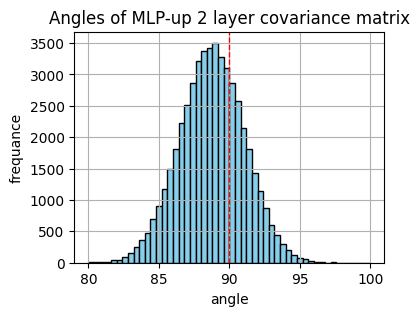

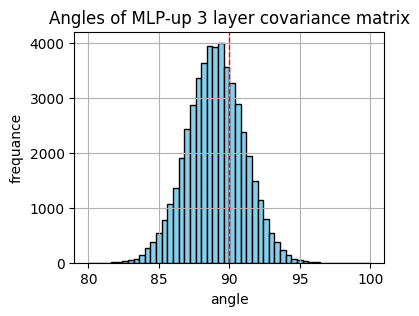

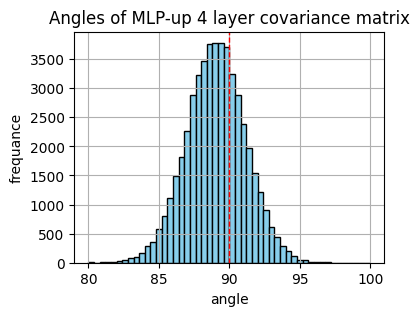

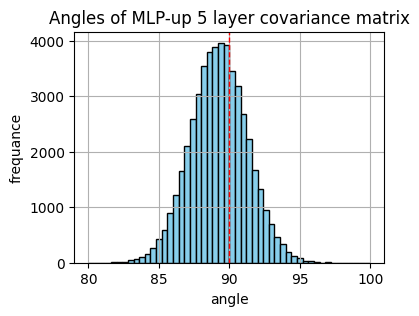

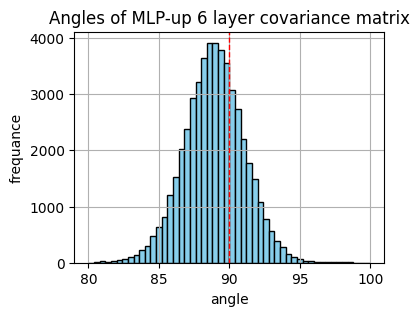

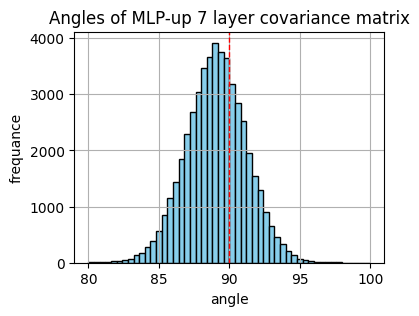

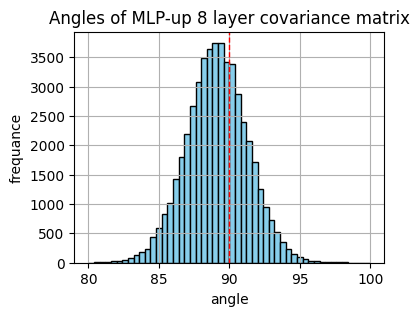

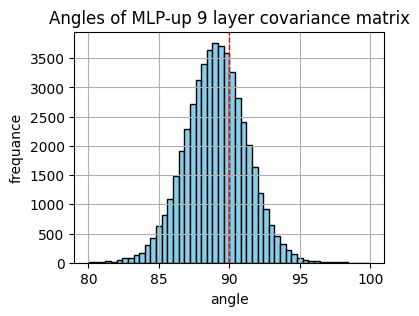

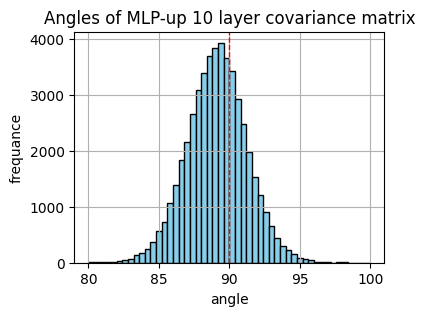

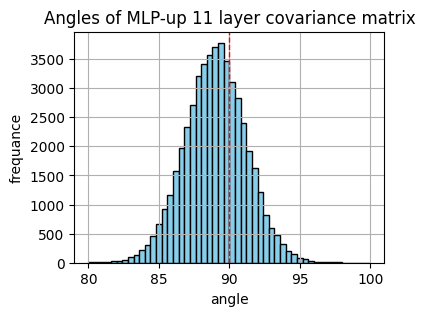

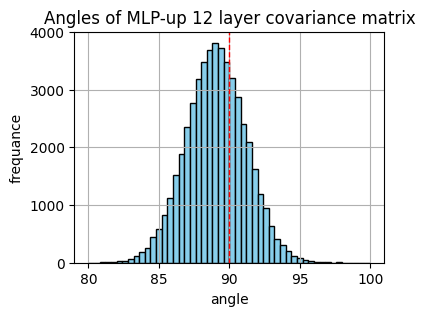

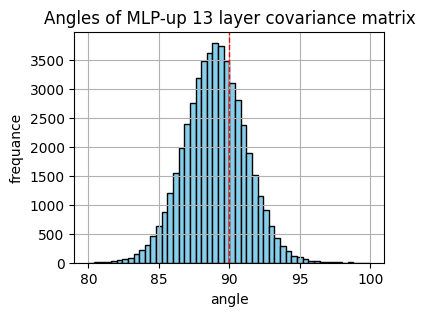

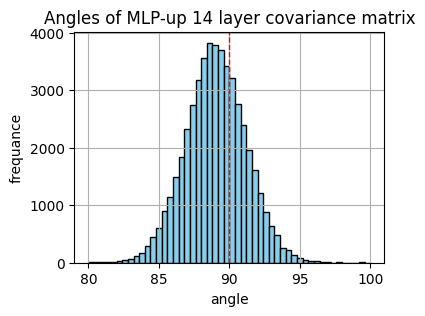

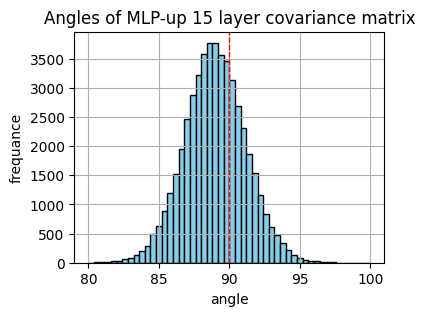

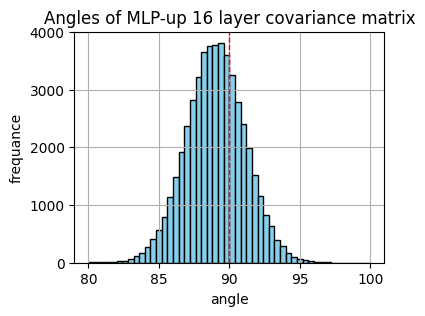

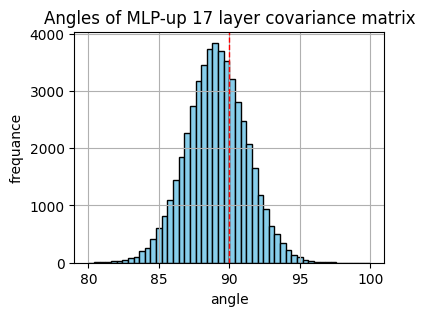

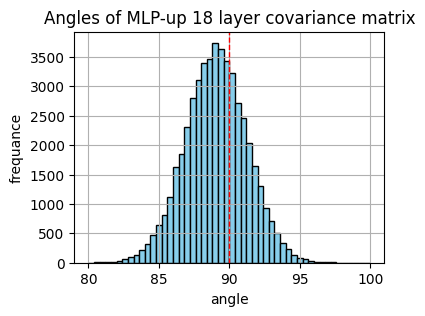

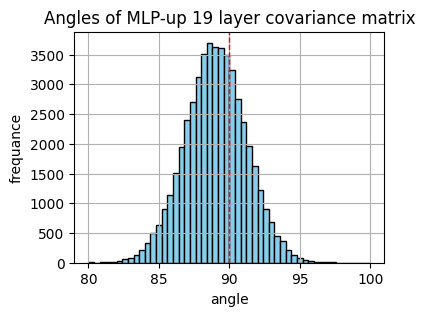

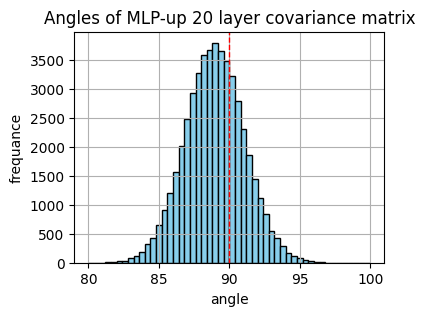

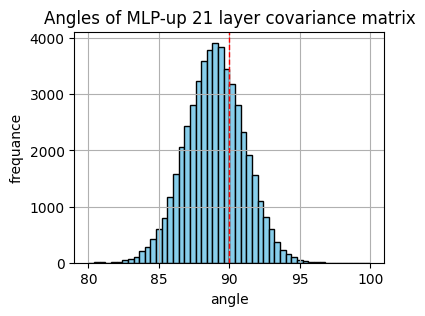

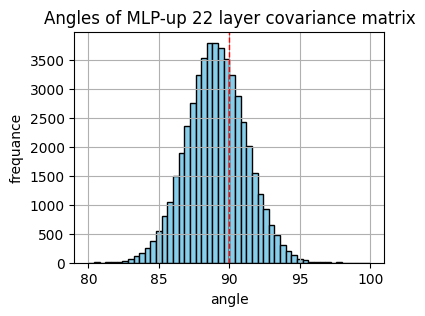

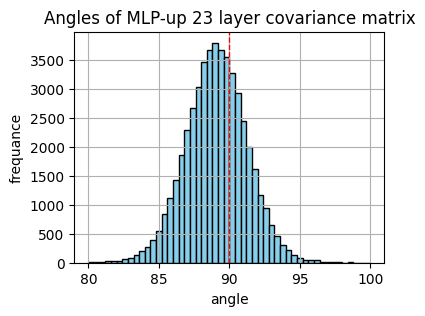

In [29]:
for layer_idx, layer in enumerate(model.layers):
  data = np.array(sigma_up_dict[layer])
  plt.figure(figsize=(4, 3))
  plt.hist(data, bins=50, range=(80, 100), color='skyblue', edgecolor='black')
  plt.axvline(90, color='red', linestyle='dashed', linewidth=1)
  plt.title(f'Angles of MLP-up {layer_idx} layer covariance matrix')
  plt.xlabel('angle')
  plt.ylabel('frequance')
  plt.grid(True)
  plt.show()